In [1]:
%pylab inline
import gc
import numpy as np
import astropy.io.fits as pyfits
import numpy.lib.recfunctions as rfn

import fpfsBase

pltDir='plot/selBias/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


In [3]:
def estimate(Clist=np.array([0.2,0.3,0.4,0.5]),C=2000.,noiRev=True):
    nsim=800
    vdir='outcome-var7em3'
    nic=len(Clist)
    gest=np.zeros((nsim,nic))
    dss=0.01
    for ifield in range(nsim):
        igroup=ifield//250
        fname1=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-2222.fits' %(igroup,ifield))
        moments1=pyfits.getdata(fname1)
        fname2=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
        moments2=pyfits.getdata(fname2)

        for ic in range(nic):
            slow=Clist[ic]
            elli1=fpfsM2E(moments1,C,rev=noiRev)
            mask2=(elli1['fpfs_s0']<=slow+dss)&(elli1['fpfs_s0']>slow)
            RS=-np.sum(elli1[mask2]['fpfs_RS'])/dss#/2.
            mask=elli1['fpfs_s0']>slow
            elli1=elli1[mask]
            g1p=np.sum(elli1['fpfs_e1'])
            downp=(np.sum(elli1['fpfs_RE'])+RS)

            elli2=fpfsM2E(moments2,C,rev=noiRev)
            mask2=(elli2['fpfs_s0']<=slow+dss)&(elli2['fpfs_s0']>slow)
            RS=-np.sum(elli2[mask2]['fpfs_RS'])/dss#/2.
            mask=elli2['fpfs_s0']>slow
            elli2=elli2[mask]
            g1m=np.sum(elli2['fpfs_e1'])
            downm=(np.sum(elli2['fpfs_RE'])+RS)

            gest[ifield,ic]=(g1m-g1p)/(downm+downp)*2.
            del elli1,elli2,mask,mask2
            gc.collect
        del moments1,moments2
        gc.collect
    return np.average(gest,axis=0)/0.04-1,np.std(gest,axis=0)/0.04/np.sqrt(nsim)

def fpfsM2E(moments,const=2000.,mcalib=0.,rev=False):
    """
    # Estimate FPFS ellipticities from fpfs moments

    Parameters:
    -----------
    moments:    input FPFS moments     [float array]
    const:      the weighting Constant [float]
    mcalib:     multiplicative bias [float array]

    Returns:
    -------------
    out :       an array of FPFS ellipticities,
                FPFS ellipticity response,
                FPFS flux ratio, and FPFS selection response
    """
    #Get weight
    weight  =   1./(moments['fpfs_M00']+const)
    #Ellipticity
    e1      =   moments['fpfs_M22c']*weight
    e2      =   moments['fpfs_M22s']*weight
    e1sq    =   e1*e1
    e2sq    =   e2*e2
    #FPFS flux ratio
    s0      =   moments['fpfs_M00']*weight
    s4      =   moments['fpfs_M40']*weight
    #FPFS sel Respose (part1)
    e1sqS0  =   e1sq*s0
    e2sqS0  =   e2sq*s0

    if rev:
        assert 'fpfs_N00N00' in moments.dtype.names
        assert 'fpfs_N00N22c' in moments.dtype.names
        assert 'fpfs_N00N22s' in moments.dtype.names
        assert 'fpfs_N00N40' in moments.dtype.names
        ratio=  moments['fpfs_N00N00']*weight**2.
        weight= weight/(1+ratio)
        ratio=  moments['fpfs_N00N00']*weight**2.
        
        e1  =   (e1+moments['fpfs_N00N22c']\
                *weight**2.)/(1+ratio)
        e2  =   (e2+moments['fpfs_N00N22s']\
                *weight**2.)/(1+ratio)
        e1sq=   (e1sq-moments['fpfs_N22cN22c']*weight**2.\
                +4.*e1*moments['fpfs_N00N22c']*weight**2.)\
                /(1.+3*ratio)
        e2sq=   (e2sq-moments['fpfs_N22sN22s']*weight**2.\
                +4.*e2*moments['fpfs_N00N22s']*weight**2.)\
                /(1.+3*ratio)
        s0  =   (s0+moments['fpfs_N00N00']\
                *weight**2.)/(1+ratio)
        s4  =   (s4+moments['fpfs_N00N40']\
                *weight**2.)/(1+ratio)
        
        e1sqS0= (e1sqS0+3.*e1sq*moments['fpfs_N00N00']*weight**2.\
                -s0*moments['fpfs_N22cN22c']*weight**2.\
                -2*e1*(1-3*s0)*moments['fpfs_N00N22c']*weight**2.\
                 )/(1+6.*ratio)
        e2sqS0= (e2sqS0+3.*e2sq*moments['fpfs_N00N00']*weight**2.\
                -s0*moments['fpfs_N22sN22s']*weight**2.\
                -2*e2*(1-3*s0)*moments['fpfs_N00N22s']*weight**2.\
                 )/(1+6.*ratio)
        
    eSq     =   e1sq+e2sq
    eSqS0   =   e1sqS0+e2sqS0
    #Response factor
    RE      =   1./np.sqrt(2.)*(s0-s4+e1sq+e2sq)
    types   =   [('fpfs_e1','>f8'),('fpfs_e2','>f8'),('fpfs_RE','>f8'),\
                ('fpfs_s0','>f8'), ('fpfs_eSquare','>f8'), ('fpfs_RS','>f8')]
    ellDat  =   np.array(np.zeros(moments.size),dtype=types)
    ellDat['fpfs_e1']   =   e1
    ellDat['fpfs_e2']   =   e2
    ellDat['fpfs_RE']   =   RE
    ellDat['fpfs_s0']   =   s0
    ellDat['fpfs_eSquare']  =   eSq
    ellDat['fpfs_RS']   =   (eSq-eSqS0)/np.sqrt(2.)
    return ellDat

In [4]:
CBase1=2000.
CBase2=4000.
Cutlist=np.linspace(0.,0.4,8)
mT,merrT=estimate(Cutlist,C=CBase1,noiRev=True)
mF,merrF=estimate(Cutlist,C=CBase2,noiRev=True)

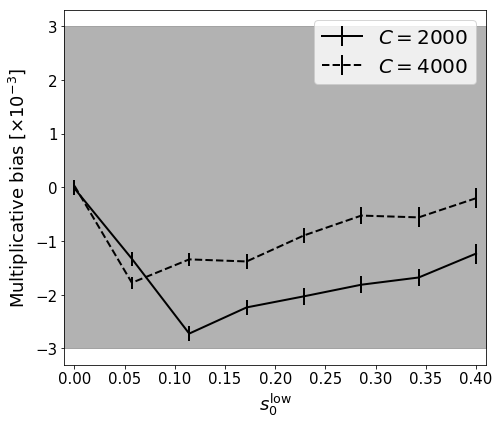

In [6]:
plt.close()
fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)
ax.errorbar(Cutlist,mT*1000,merrT*1000,fmt='-',c='black',linewidth=2,label=r'$C=2000$')
ax.errorbar(Cutlist,mF*1000,merrF*1000,fmt='--',c='black',linewidth=2,label=r'$C=4000$')
ax.fill_between(np.linspace(-0.01,0.41,100),-3e0*np.ones(100),3e0*np.ones(100),color='gray',alpha=0.6)
ax.set_xlim(-0.01,0.41)
ax.set_xlabel(r'$s_0^{\rm low}$')
ax.set_ylabel(r'Multiplicative bias [$\times 10^{-3}$]')
ax.legend()
plt.tight_layout()
fig.savefig(os.path.join(pltDir,'selBias_wnoise_low.png'))
fig.savefig(os.path.join(pltDir,'selBias_wnoise_low.pdf'))

In [13]:
vdir='outcome-var7em3'
allS01=[]
allS02=[]
for igroup in range(8):
    ifield=igroup*250
    fname1=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
    moments1=pyfits.getdata(fname1)
    elli1=fpfsM2E(moments1,CBase1,rev=True)
    allS01.append(elli1['fpfs_s0'])
    elli2=fpfsM2E(moments1,CBase2,rev=True)
    allS02.append(elli2['fpfs_s0'])
    del elli1,elli2
    gc.collect()
allS01=rfn.stack_arrays(allS01,usemask=False)
allS02=rfn.stack_arrays(allS02,usemask=False)

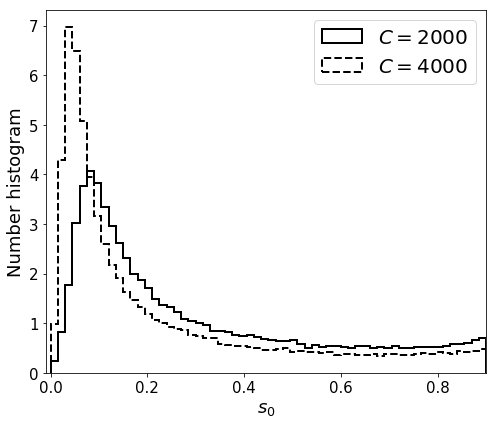

In [14]:
plt.close()
fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)
ax.hist(allS01,bins=60,range=(0.,0.9),density=True,color='black',histtype='step',linewidth=2.,ls='-',label=r'$C=2000$')
ax.hist(allS02,bins=60,range=(0.,0.9),density=True,color='black',histtype='step',linewidth=2.,ls='--',label=r'$C=4000$')
ax.set_xlabel(r'$s_0$')
ax.set_ylabel(r'Number histogram')
ax.set_xlim(-0.01,0.9)
ax.legend()
plt.tight_layout()
fig.savefig(os.path.join(pltDir,'histS0.png'))
fig.savefig(os.path.join(pltDir,'histS0.pdf'))

In [10]:
def estimateA(Clist=np.array([0.2,0.3,0.4,0.5]),C=2000.,noiRev=True):
    nsim=2000
    vdir='outcome-var7em3'
    nic=len(Clist)
    gest=np.zeros((nsim,nic))
    dss=0.01
    for ifield in range(nsim):
        igroup=ifield//250
        fname1=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-1111.fits' %(igroup,ifield))
        moments1=pyfits.getdata(fname1)
        fname2=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-1111.fits' %(igroup+8,ifield+2000))
        moments2=pyfits.getdata(fname2)

        for ic in range(nic):
            slow=Clist[ic]
            
            elli1=fpfsM2E(moments1,C,rev=noiRev)
            mask2=(elli1['fpfs_s0']<=slow+dss)&(elli1['fpfs_s0']>slow)
            RS=-np.sum(elli1[mask2]['fpfs_RS'])/dss#/2.
            mask=elli1['fpfs_s0']>slow
            elli1=elli1[mask]
            g1p=np.sum(elli1['fpfs_e1'])/(np.sum(elli1['fpfs_RE'])+RS)
            
            elli2=fpfsM2E(moments2,C,rev=noiRev)
            mask2=(elli2['fpfs_s0']<=slow+dss)&(elli2['fpfs_s0']>slow)
            RS=-np.sum(elli2[mask2]['fpfs_RS'])/dss#/2.
            mask=elli2['fpfs_s0']>slow
            elli2=elli2[mask]
            g1m=np.sum(elli2['fpfs_e1'])/(np.sum(elli2['fpfs_RE'])+RS)

            gest[ifield,ic]=(g1m+g1p)/2.
            del elli2,mask,mask2
            gc.collect
        del moments2
        gc.collect
    return np.average(gest,axis=0),np.std(gest,axis=0)/np.sqrt(nsim)

def measure(galImgAll):
    imgList=[galImgAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end] for i in range(ngal)]
    a=fpTask.measure(imgList)
    del imgList
    gc.collect()
    return a

CBase1=2000.
CBase2=4000.
Cutlist=np.linspace(0.,0.4,8)
cT,cerrT=estimateA(Cutlist,C=CBase1,noiRev=False)
cF,cerrF=estimateA(Cutlist,C=CBase2,noiRev=False)

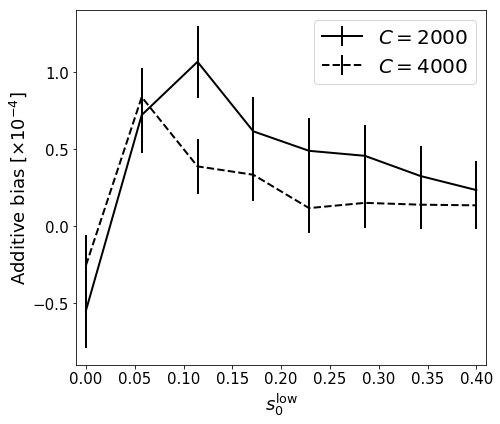

In [11]:
plt.close()
fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)
ax.errorbar(Cutlist,cT*1e4,cerrT*1e4,fmt='-',c='black',linewidth=2,label=r'$C=2000$')
ax.errorbar(Cutlist,cF*1e4,cerrF*1e4,fmt='--',c='black',linewidth=2,label=r'$C=4000$')
#ax.fill_between(np.linspace(-0.01,0.41,100),-3e0*np.ones(100),3e0*np.ones(100),color='gray',alpha=0.6)
ax.set_xlim(-0.01,0.41)
ax.set_xlabel(r'$s_0^{\rm low}$')
ax.set_ylabel(r'Additive bias [$\times 10^{-4}$]')
ax.legend()
plt.tight_layout()
fig.savefig(os.path.join(pltDir,'selBiasA_wnoise_low.png'))
fig.savefig(os.path.join(pltDir,'selBiasA_wnoise_low.pdf'))